# World Trade Regression — End-to-End Notebook

Goal: Predict export_value_usd_mln using multiple regression models, compare performance (MAE/RMSE/R²), and build ensembles (Voting & Stacking).

Dataset: world_trade_synth_fast.csv (columns include year, trade pair info, quantities, prices, macro indicators).

Deliverables: clean preprocessing, top models, robust evaluation, tuned models, ensemble, saved best model

#### Importing all necessary Libraries

In [47]:
# Core
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Models
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR

# Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
    HistGradientBoostingRegressor, BaggingRegressor, StackingRegressor, VotingRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor


import warnings
warnings.filterwarnings("ignore")

# Set plotting style
sns.set(style="whitegrid")

# Storage for model results
model_results = []
model_predictions = {}


#### Loading the dataset

In [12]:
# Replace with your dataset
df = pd.read_csv("world_trade_synth_fast.csv")

print(df.shape)
df.head()


(1000000, 16)


,year,reporter_iso3,partner_iso3,product_code,distance_km,fta_active,adval_tariff_pct,reporter_gdp_bln,partner_gdp_bln,reporter_pop_m,partner_pop_m,reporter_cpi,partner_cpi,export_value_usd_mln,quantity_tonnes,unit_price_usd_per_tonne
0,1975,USA,DZA,AGRI,5273.4,0,9.23,180.484,443.922,48.765,10.598,51.95,53.25,1.703,58.330,29191.463644
1,1975,USA,DZA,ENER,5273.4,0,14.81,180.484,443.922,48.765,10.598,51.95,53.25,2.213,75.814,29191.463644
2,1975,USA,DZA,META,5273.4,0,9.57,180.484,443.922,48.765,10.598,51.95,53.25,0.883,30.262,29191.463644
3,1975,USA,DZA,CHEM,5273.4,0,9.15,180.484,443.922,48.765,10.598,51.95,53.25,4.917,168.447,29191.463644
4,1975,USA,DZA,MACH,5273.4,0,3.99,180.484,443.922,48.765,10.598,51.95,53.25,15.236,521.919,29191.463644


## Exploratory Data Analysis.

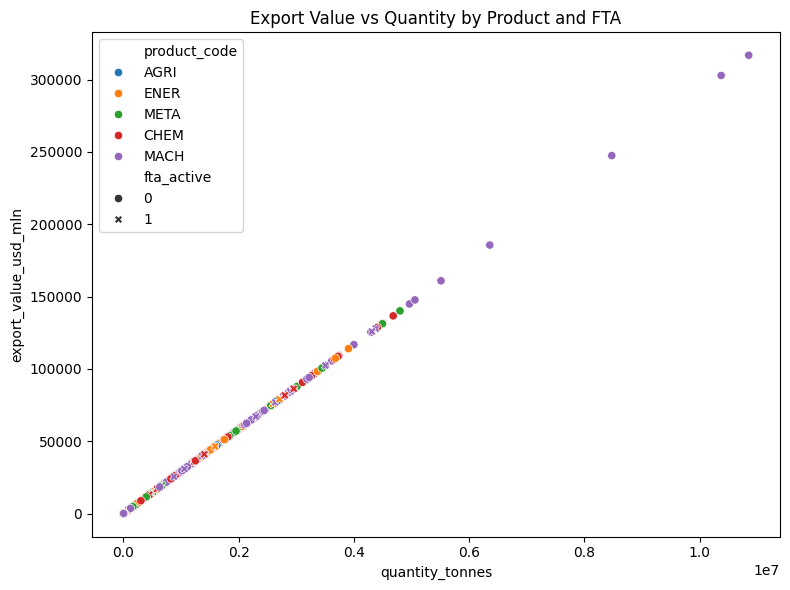

In [13]:
# 1. Scatter plot: Export Value by Quantity (color by Product)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='quantity_tonnes', y='export_value_usd_mln', hue='product_code', style='fta_active')
plt.title("Export Value vs Quantity by Product and FTA")
plt.tight_layout()
plt.show()

C:\Users\meher\AppData\Local\Temp\ipykernel_252\685780865.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='product_code', y='unit_price_usd_per_tonne', data=df, inner='quartile', palette='muted')


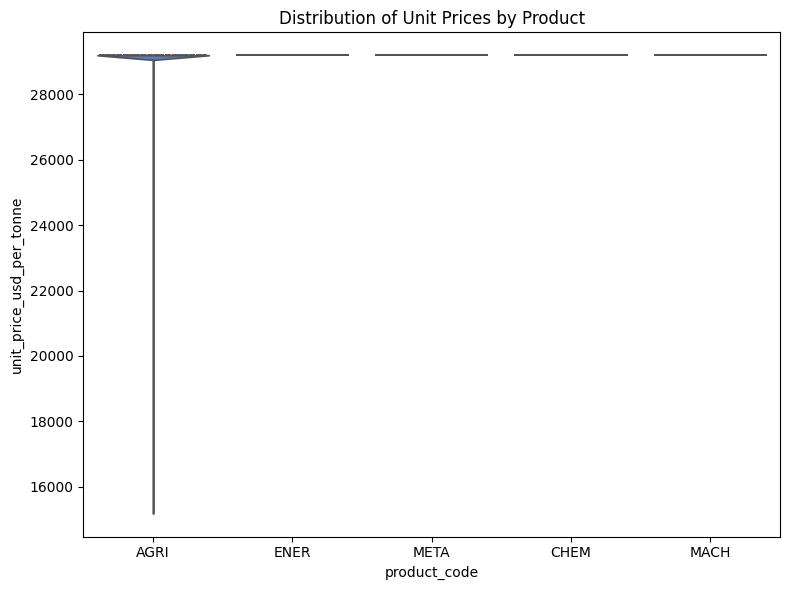

In [14]:
# 2. Distribution: Unit Price per Tonne by Product
plt.figure(figsize=(8, 6))
sns.violinplot(x='product_code', y='unit_price_usd_per_tonne', data=df, inner='quartile', palette='muted')
plt.title("Distribution of Unit Prices by Product")
plt.tight_layout()
plt.show()

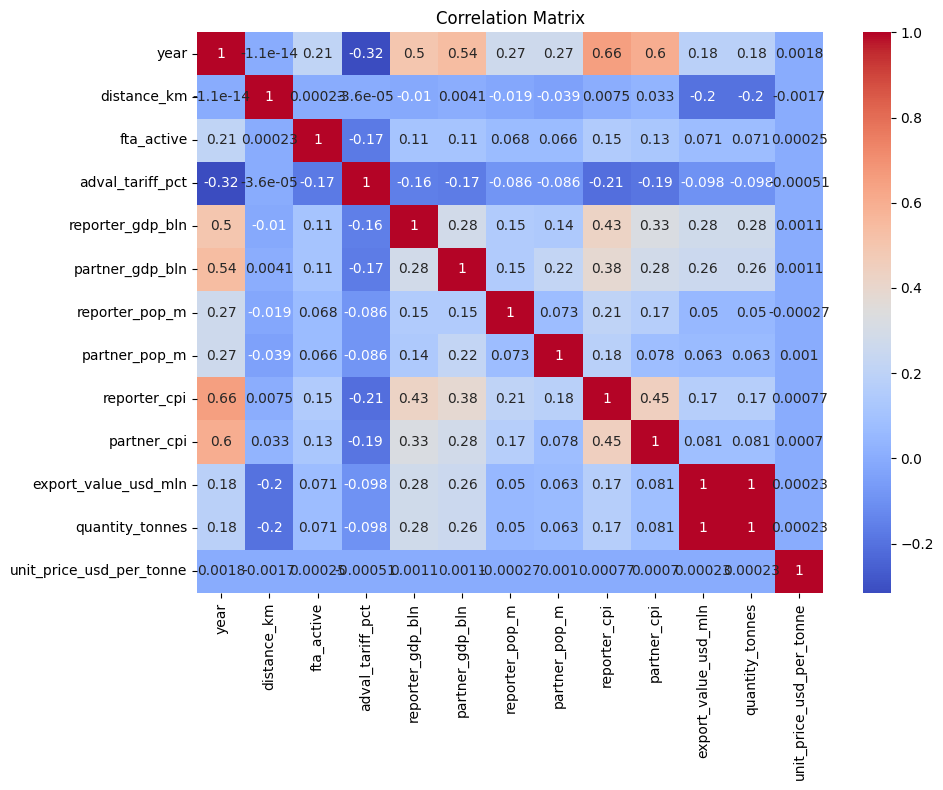

In [15]:
# 3. Heatmap: Correlation Matrix (only numeric)
plt.figure(figsize=(10, 8))
sns.heatmap(df.select_dtypes('number').corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

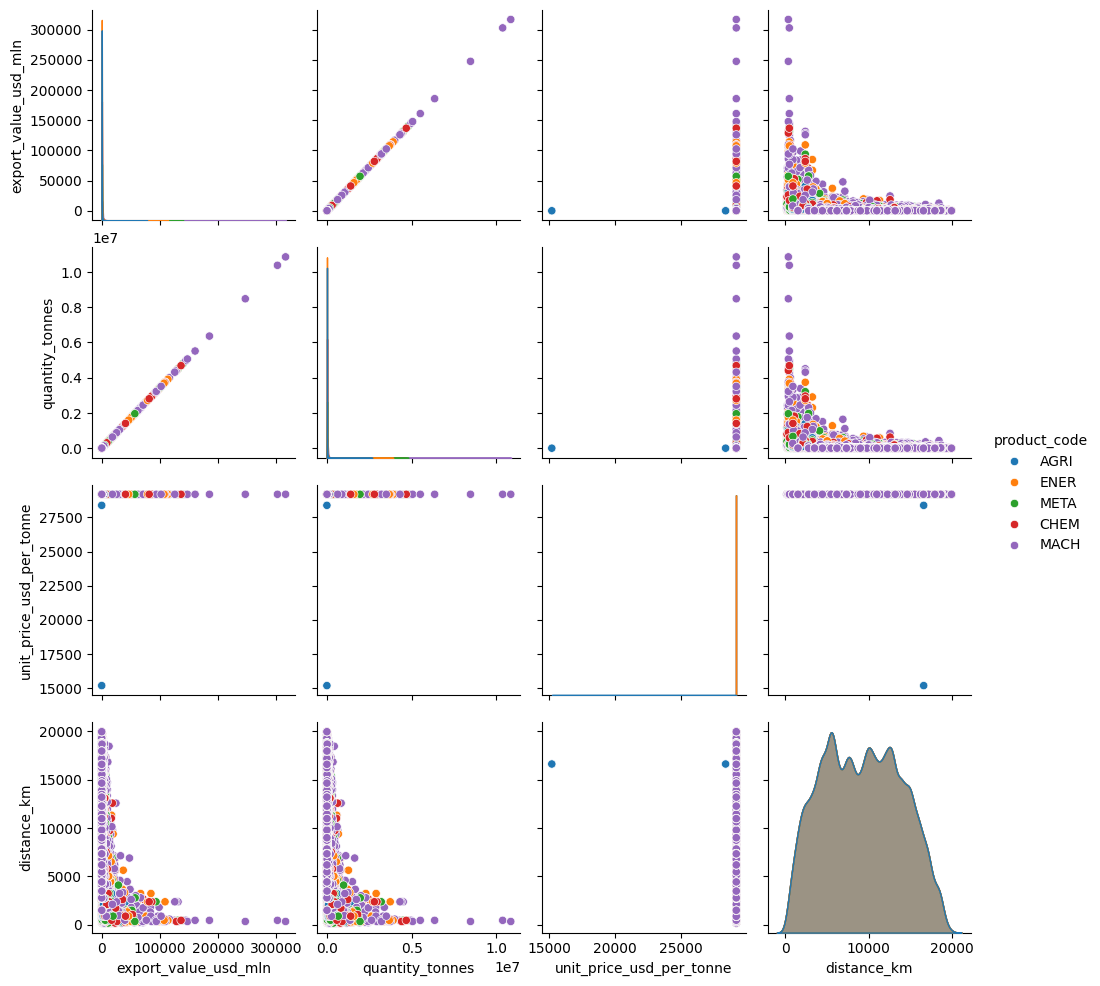

In [16]:
# 4. Pairplot: Key Variables (colored by Product)
sns.pairplot(df, vars=['export_value_usd_mln','quantity_tonnes','unit_price_usd_per_tonne','distance_km'], hue='product_code')
plt.show()

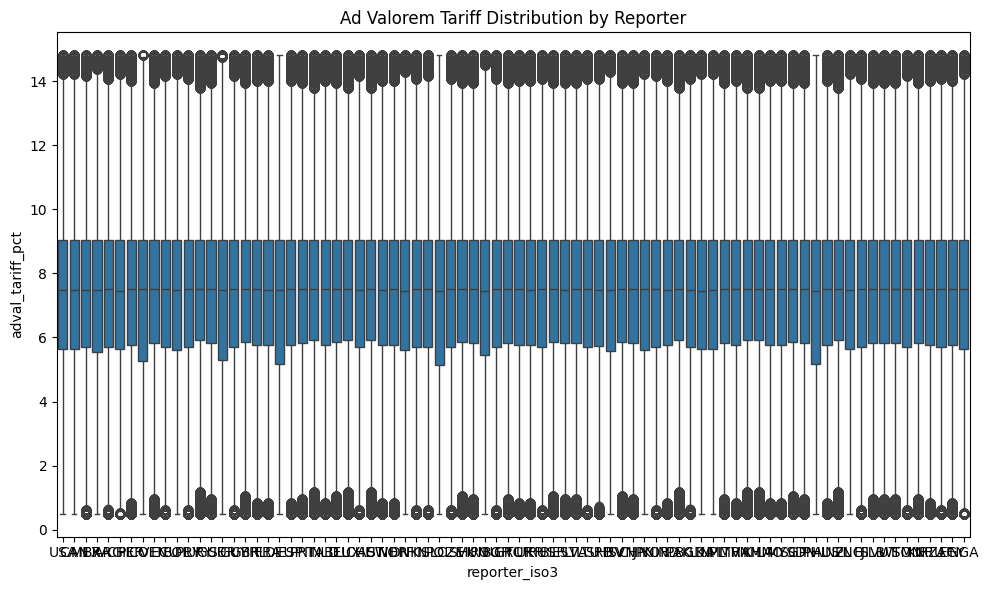

In [17]:
# 5. Boxplot: Ad Valorem Tariff Percent by Reporter
plt.figure(figsize=(10, 6))
sns.boxplot(x='reporter_iso3', y='adval_tariff_pct', data=df)
plt.title('Ad Valorem Tariff Distribution by Reporter')
plt.tight_layout()
plt.show()

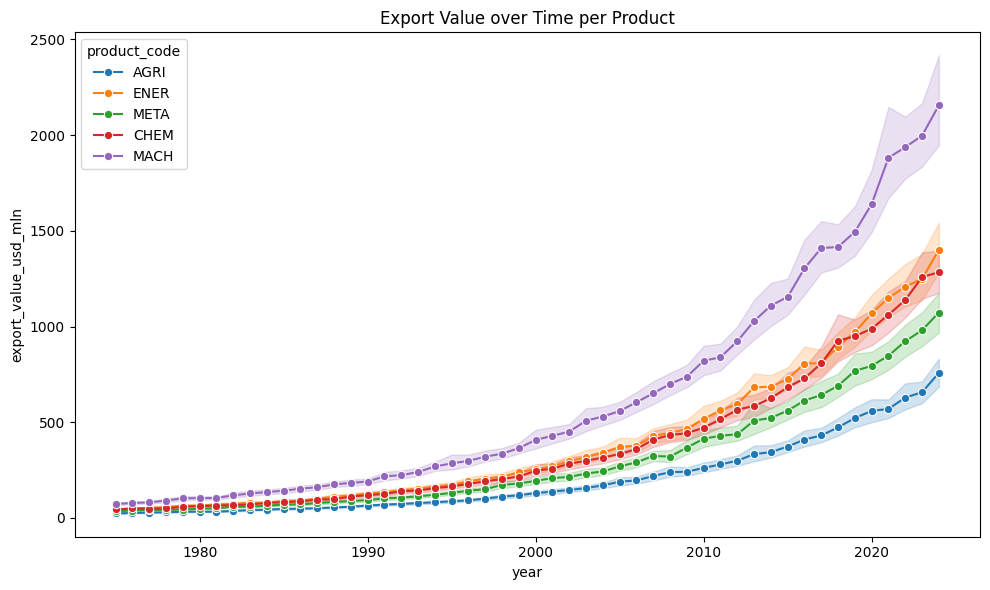

In [18]:
# 6. Linechart: Export Value over Years by Product
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='year', y='export_value_usd_mln', hue='product_code', marker='o')
plt.title("Export Value over Time per Product")
plt.tight_layout()
plt.show()

C:\Users\meher\AppData\Local\Temp\ipykernel_252\1759778072.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(data=df, x='reporter_iso3', y='unit_price_usd_per_tonne', estimator='mean', ci='sd')


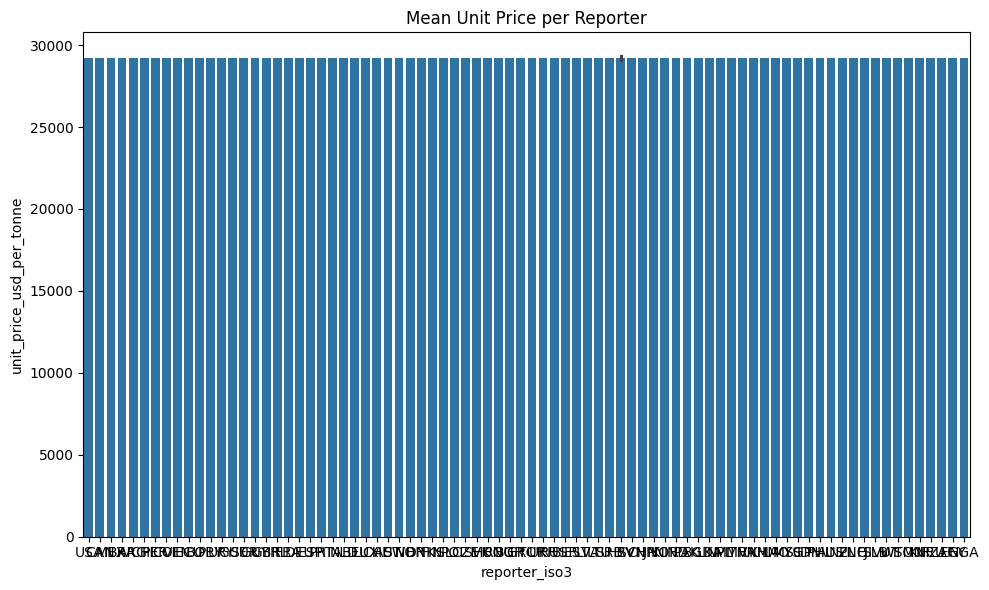

In [19]:
# 7. Barplot: Mean Unit Price per Reporter
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='reporter_iso3', y='unit_price_usd_per_tonne', estimator='mean', ci='sd')
plt.title("Mean Unit Price per Reporter")
plt.tight_layout()
plt.show()

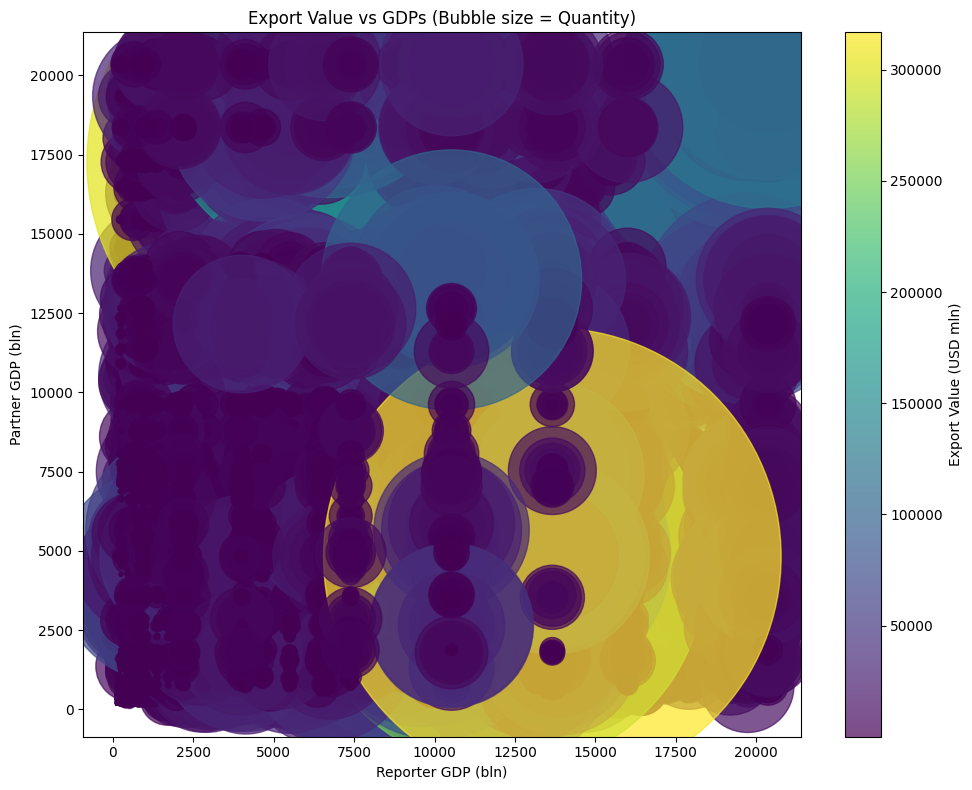

In [20]:
# 8. Bubble Chart: Export Value vs GDP (Reporter and Partner, bubble size=Quantity)
plt.figure(figsize=(10, 8))
plt.scatter(df['reporter_gdp_bln'], df['partner_gdp_bln'], s=df['quantity_tonnes']/100, c=df['export_value_usd_mln'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Export Value (USD mln)')
plt.xlabel('Reporter GDP (bln)')
plt.ylabel('Partner GDP (bln)')
plt.title('Export Value vs GDPs (Bubble size = Quantity)')
plt.tight_layout()
plt.show()

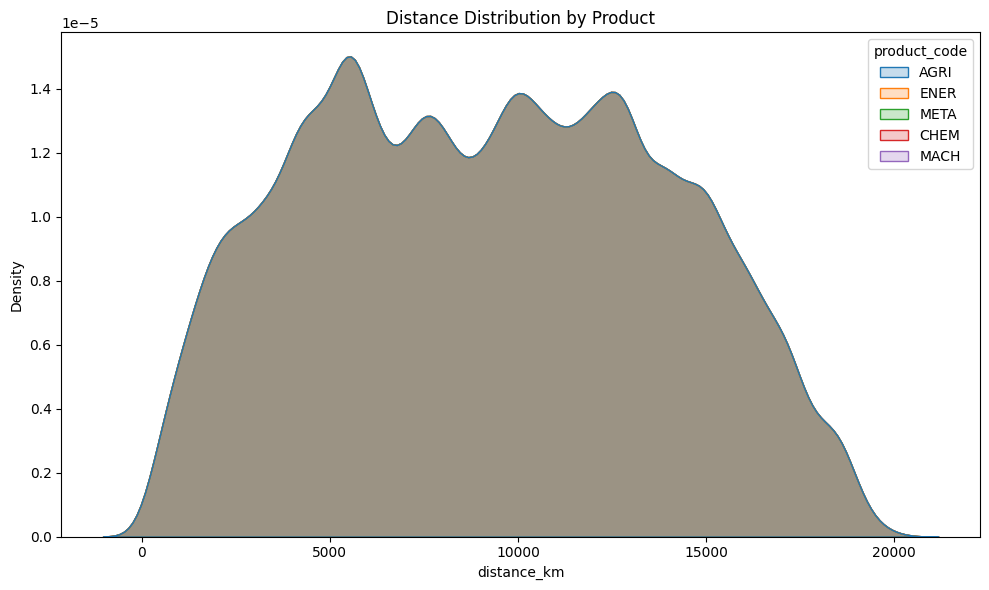

In [21]:
# 9. KDE Plot: Distance Distribution (by Product)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='distance_km', hue='product_code', fill=True)
plt.title("Distance Distribution by Product")
plt.tight_layout()
plt.show()

In [ ]:
# # 10. Swarmplot: FTA Active vs Unit Price (by Product)
# plt.figure(figsize=(10, 6))
# sns.swarmplot(data=df, x='fta_active', y='unit_price_usd_per_tonne', hue='product_code')
# plt.title("Unit Price by FTA Status and Product")
# plt.tight_layout()
# plt.show()

#### Train - test split.

In [24]:
# Suppose 'target' is the column we want to predict
target_col = "export_value_usd_mln"  # <-- replace with your column name
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [25]:
X_train

,year,reporter_iso3,partner_iso3,product_code,distance_km,fta_active,adval_tariff_pct,reporter_gdp_bln,partner_gdp_bln,reporter_pop_m,partner_pop_m,reporter_cpi,partner_cpi,quantity_tonnes,unit_price_usd_per_tonne
506532,2000,CHE,UGA,META,2389.1,0,7.73,981.097,2933.831,72.792,121.368,238.60,154.50,4434.565,29191.463644
327991,1991,FIN,X129,ENER,17716.6,0,13.63,484.300,406.045,22.605,37.863,131.94,88.86,50.277,29191.463644
715937,2010,MYS,X118,META,9396.0,1,4.99,3574.602,1053.705,134.767,135.427,751.01,355.96,2211.088,29191.463644
860726,2018,MEX,X126,ENER,17512.0,0,11.65,1742.703,6075.752,126.834,283.533,101.05,593.22,1847.166,29191.463644
78617,1978,TON,X104,META,14527.4,0,9.35,2030.509,569.053,65.831,57.198,62.81,60.54,390.307,29191.463644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,1987,NRU,X116,CHEM,11540.9,0,8.26,2563.178,1888.851,141.092,95.429,122.86,127.19,2024.439,29191.463644
365838,1993,NLD,X098,CHEM,5874.4,0,7.82,1838.273,3112.379,83.554,66.914,202.83,98.70,2898.057,29191.463644
131932,1981,SRB,X117,META,8370.9,0,9.13,1027.203,1744.672,118.219,43.564,76.69,60.69,863.182,29191.463644
671155,2008,EST,X112,AGRI,7304.0,0,6.80,5511.570,1922.277,59.074,138.680,486.50,213.21,10915.814,29191.463644


In [26]:
X_test

,year,reporter_iso3,partner_iso3,product_code,distance_km,fta_active,adval_tariff_pct,reporter_gdp_bln,partner_gdp_bln,reporter_pop_m,partner_pop_m,reporter_cpi,partner_cpi,quantity_tonnes,unit_price_usd_per_tonne
987231,2024,SWE,X127,ENER,13368.2,0,11.21,4845.595,3608.810,321.090,202.698,572.17,303.27,7665.263,29191.463644
79954,1978,NGA,X121,MACH,8746.9,0,3.77,92.941,1077.580,32.487,22.601,54.47,64.25,128.848,29191.463644
567130,2003,SWE,X107,AGRI,11906.6,0,7.17,3075.939,780.677,221.797,12.469,207.15,358.74,2230.687,29191.463644
500891,2000,BRA,X109,ENER,5247.2,0,12.97,657.950,1567.471,83.113,96.722,244.43,89.38,1833.139,29191.463644
55399,1977,KHM,X110,MACH,9959.7,0,3.84,330.330,1350.800,147.797,56.589,54.33,60.71,562.817,29191.463644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463299,1998,GUF,SEN,MACH,19258.0,0,2.30,4647.120,2097.992,103.375,116.404,169.74,207.69,3728.226,29191.463644
728324,2011,POL,MOZ,MACH,12055.0,0,1.34,6008.649,3248.562,196.885,125.855,396.14,87.64,29735.948,29191.463644
76260,1978,IDN,TUN,AGRI,10633.7,0,9.01,312.711,2108.153,153.134,106.813,57.62,55.48,104.356,29191.463644
77813,1978,SLB,ZWE,CHEM,1141.6,0,8.92,957.813,1830.455,99.117,27.610,56.45,60.34,14920.861,29191.463644


In [28]:
y_train

506532    129.451
327991      1.468
715937     64.545
860726     53.921
78617      11.394
           ...   
259178     59.096
365838     84.599
131932     25.198
671155    318.649
121958     11.013
Name: export_value_usd_mln, Length: 700000, dtype: float64

In [29]:
y_test

987231    223.760
79954       3.761
567130     65.117
500891     53.512
55399      16.429
           ...   
463299    108.832
728324    868.036
76260       3.046
77813     435.562
718205    199.457
Name: export_value_usd_mln, Length: 300000, dtype: float64

## Feature Engineering

#### Detect categorical and numerical features

In [30]:
X_train['year_relative'] = X_train['year'] - X_train['year'].min()
X_train['decade'] = (X_train['year'] // 10) * 10


In [42]:
min_year = df['year'].min()

In [ ]:
X_test['relative_year'] = X_test['year'] - min_year

In [44]:
X_test['decade'] = (X_test['year'] // 10) * 10

In [32]:
X_train.drop(columns=['year'], inplace=True)

In [33]:
X_train

,reporter_iso3,partner_iso3,product_code,distance_km,fta_active,adval_tariff_pct,reporter_gdp_bln,partner_gdp_bln,reporter_pop_m,partner_pop_m,reporter_cpi,partner_cpi,quantity_tonnes,unit_price_usd_per_tonne,year_relative,decade
506532,CHE,UGA,META,2389.1,0,7.73,981.097,2933.831,72.792,121.368,238.60,154.50,4434.565,29191.463644,25,2000
327991,FIN,X129,ENER,17716.6,0,13.63,484.300,406.045,22.605,37.863,131.94,88.86,50.277,29191.463644,16,1990
715937,MYS,X118,META,9396.0,1,4.99,3574.602,1053.705,134.767,135.427,751.01,355.96,2211.088,29191.463644,35,2010
860726,MEX,X126,ENER,17512.0,0,11.65,1742.703,6075.752,126.834,283.533,101.05,593.22,1847.166,29191.463644,43,2010
78617,TON,X104,META,14527.4,0,9.35,2030.509,569.053,65.831,57.198,62.81,60.54,390.307,29191.463644,3,1970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,NRU,X116,CHEM,11540.9,0,8.26,2563.178,1888.851,141.092,95.429,122.86,127.19,2024.439,29191.463644,12,1980
365838,NLD,X098,CHEM,5874.4,0,7.82,1838.273,3112.379,83.554,66.914,202.83,98.70,2898.057,29191.463644,18,1990
131932,SRB,X117,META,8370.9,0,9.13,1027.203,1744.672,118.219,43.564,76.69,60.69,863.182,29191.463644,6,1980
671155,EST,X112,AGRI,7304.0,0,6.80,5511.570,1922.277,59.074,138.680,486.50,213.21,10915.814,29191.463644,33,2000


In [35]:
# Suppose df is your DataFrame
categorical_cols = ["reporter_iso3", "partner_iso3", "product_code"]


In [45]:
# Identify categorical and numerical columns
categorical_features = ['reporter_iso3', 'partner_iso3', 'product_code', 'fta_active', 'decade']
numerical_features = [col for col in X_train.columns if col not in categorical_features]

In [48]:
# Define transformers
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
numerical_transformer = MinMaxScaler()

In [49]:
# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
        ('num', numerical_transformer, numerical_features)
    ]
)

In [51]:
X_train

,reporter_iso3,partner_iso3,product_code,distance_km,fta_active,adval_tariff_pct,reporter_gdp_bln,partner_gdp_bln,reporter_pop_m,partner_pop_m,reporter_cpi,partner_cpi,quantity_tonnes,unit_price_usd_per_tonne,year_relative,decade
506532,CHE,UGA,META,2389.1,0,7.73,981.097,2933.831,72.792,121.368,238.60,154.50,4434.565,29191.463644,25,2000
327991,FIN,X129,ENER,17716.6,0,13.63,484.300,406.045,22.605,37.863,131.94,88.86,50.277,29191.463644,16,1990
715937,MYS,X118,META,9396.0,1,4.99,3574.602,1053.705,134.767,135.427,751.01,355.96,2211.088,29191.463644,35,2010
860726,MEX,X126,ENER,17512.0,0,11.65,1742.703,6075.752,126.834,283.533,101.05,593.22,1847.166,29191.463644,43,2010
78617,TON,X104,META,14527.4,0,9.35,2030.509,569.053,65.831,57.198,62.81,60.54,390.307,29191.463644,3,1970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,NRU,X116,CHEM,11540.9,0,8.26,2563.178,1888.851,141.092,95.429,122.86,127.19,2024.439,29191.463644,12,1980
365838,NLD,X098,CHEM,5874.4,0,7.82,1838.273,3112.379,83.554,66.914,202.83,98.70,2898.057,29191.463644,18,1990
131932,SRB,X117,META,8370.9,0,9.13,1027.203,1744.672,118.219,43.564,76.69,60.69,863.182,29191.463644,6,1980
671155,EST,X112,AGRI,7304.0,0,6.80,5511.570,1922.277,59.074,138.680,486.50,213.21,10915.814,29191.463644,33,2000


In [52]:
X_test

,year,reporter_iso3,partner_iso3,product_code,distance_km,fta_active,adval_tariff_pct,reporter_gdp_bln,partner_gdp_bln,reporter_pop_m,partner_pop_m,reporter_cpi,partner_cpi,quantity_tonnes,unit_price_usd_per_tonne,relative_year,decade
987231,2024,SWE,X127,ENER,13368.2,0,11.21,4845.595,3608.810,321.090,202.698,572.17,303.27,7665.263,29191.463644,49,2020
79954,1978,NGA,X121,MACH,8746.9,0,3.77,92.941,1077.580,32.487,22.601,54.47,64.25,128.848,29191.463644,3,1970
567130,2003,SWE,X107,AGRI,11906.6,0,7.17,3075.939,780.677,221.797,12.469,207.15,358.74,2230.687,29191.463644,28,2000
500891,2000,BRA,X109,ENER,5247.2,0,12.97,657.950,1567.471,83.113,96.722,244.43,89.38,1833.139,29191.463644,25,2000
55399,1977,KHM,X110,MACH,9959.7,0,3.84,330.330,1350.800,147.797,56.589,54.33,60.71,562.817,29191.463644,2,1970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
463299,1998,GUF,SEN,MACH,19258.0,0,2.30,4647.120,2097.992,103.375,116.404,169.74,207.69,3728.226,29191.463644,23,1990
728324,2011,POL,MOZ,MACH,12055.0,0,1.34,6008.649,3248.562,196.885,125.855,396.14,87.64,29735.948,29191.463644,36,2010
76260,1978,IDN,TUN,AGRI,10633.7,0,9.01,312.711,2108.153,153.134,106.813,57.62,55.48,104.356,29191.463644,3,1970
77813,1978,SLB,ZWE,CHEM,1141.6,0,8.92,957.813,1830.455,99.117,27.610,56.45,60.34,14920.861,29191.463644,3,1970


In [53]:
X_test.rename(columns={'relative_year': 'year_relative'}, inplace=True)


In [54]:
# Fit on X_train, transform both X_train and X_test
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

In [55]:
X_train_processed

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.08543705e-04, 1.00000000e+00, 5.10204082e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.58450673e-06, 1.00000000e+00, 3.26530612e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.03677148e-04, 1.00000000e+00, 7.14285714e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.94838865e-05, 1.00000000e+00, 1.22448980e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.00571254e-03, 1.00000000e+00, 6.73469388e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.47140689e-05, 1.00000000e+00, 1.22448980e-01]])

In [56]:
# If you want back into DataFrame with column names
# Get feature names
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
num_feature_names = numerical_features
all_feature_names = list(ohe_feature_names) + num_feature_names

X_train_df = pd.DataFrame(X_train_processed, columns=all_feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=all_feature_names, index=X_test.index)

In [ ]:
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessor: OneHot for categorical, Scale for numeric
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)

In [ ]:
df.head()

#### Defining Evaluation Function

In [ ]:
# models = {
#     "Linear Regression": LinearRegression(),
#     "Ridge Regression": Ridge(),
#     "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
#     "Gradient Boosting": GradientBoostingRegressor(n_estimators=200, random_state=42),
#     "Hist Gradient Boosting": HistGradientBoostingRegressor(random_state=42)
# }


In [58]:
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    results = {
        'Model': model_name,
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2 Score': r2
    }
    
    return results


#### Defining Function to Train, Predict, Evaluate and Visualize

In [59]:
def run_model(model_name, model, X_train, X_test, y_train, y_test):
    print(f"\n{'='*30}")
    print(f"🚀 Running Model: {model_name}")
    print(f"{'='*30}\n")

    # Pipeline: Standardization + Model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('regressor', model)
    ])

    # Train
    pipeline.fit(X_train, y_train)

    # Predict
    y_pred = pipeline.predict(X_test)

    # Evaluate
    results = evaluate_model(model_name, y_test, y_pred)
    model_results.append(results)
    model_predictions[model_name] = y_pred

    # Print Metrics
    print(f"📊 Evaluation Metrics for {model_name}:\n")
    for k, v in results.items():
        if k != 'Model':
            print(f"{k:<12}: {v:.4f}")
    print()

    # Plot Actual vs Predicted
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
    plt.tight_layout()
    plt.show()

    # Residual Plot
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{model_name} - Residual Distribution")
    plt.xlabel("Residuals")
    plt.tight_layout()
    plt.show()

    # Return trained pipeline (optional)
    return pipeline


#### Train & Evaluate Models


🚀 Running Model: Linear Regression

📊 Evaluation Metrics for Linear Regression:

MAE         : 0.0002
MSE         : 0.0000
RMSE        : 0.0003
R2 Score    : 1.0000



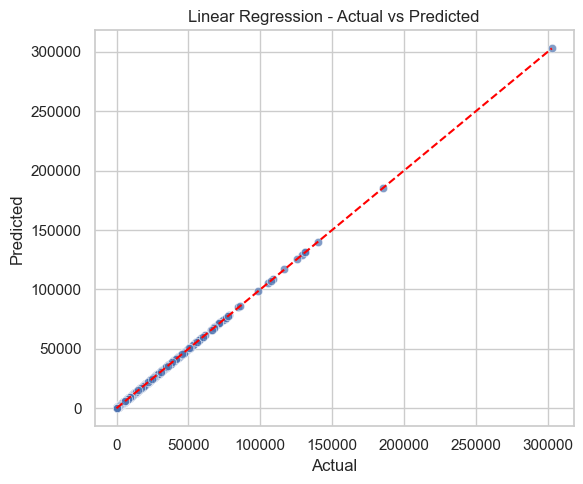

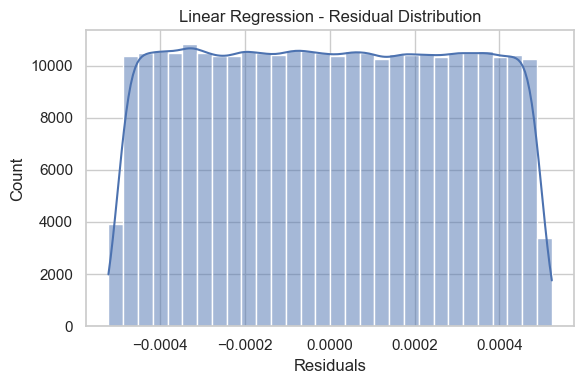

In [60]:
lr_model = LinearRegression()
lr_pipeline = run_model("Linear Regression", lr_model, X_train_df, X_test_df, y_train, y_test)


🚀 Running Model: Random Forest

📊 Evaluation Metrics for Random Forest:

MAE         : 0.7181
MSE         : 28742.2746
RMSE        : 169.5355
R2 Score    : 0.9914



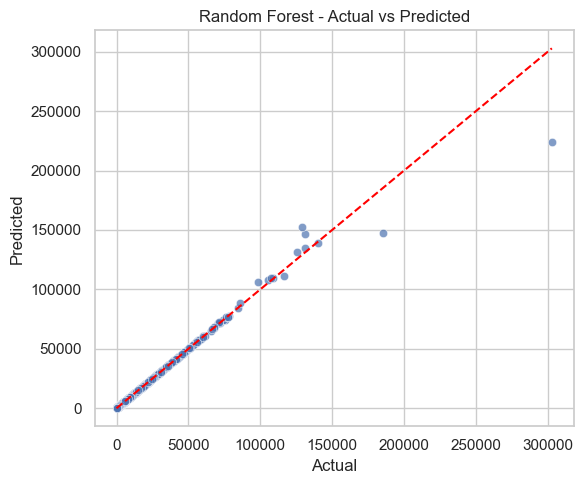

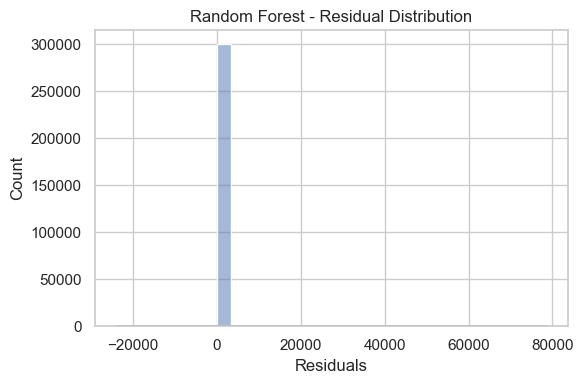

In [61]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(random_state=42)
rf_pipeline = run_model("Random Forest", rf_model, X_train_df, X_test_df, y_train, y_test)


In [ ]:
# Base models
base_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "SVR": make_pipeline(StandardScaler(), SVR()),  # Needs scaling
    "KNN Regressor": make_pipeline(StandardScaler(), KNeighborsRegressor()),  # Needs scaling
    "MLP Regressor": make_pipeline(StandardScaler(), MLPRegressor(random_state=42, max_iter=500))
}

#### Bagging with base models

In [ ]:
bagging_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=42)

#### Voting (combining top base models)

In [ ]:
voting_model = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42, verbosity=0)),
    ('lgbm', LGBMRegressor(random_state=42, verbose=-1)),
])

In [ ]:
ensemble_models = {
    "Bagging": bagging_model,
    "Voting": voting_model,
    "Stacking": stacking_model
}

# Merge all models into one final dictionary
all_models = {**base_models, **ensemble_models}


#### Run through all models

In [ ]:
for name, model in all_models.items():
    run_model(name, model, X_train_df, X_test_df, y_train, y_test)



🚀 Running Model: Gradient Boosting

📊 Evaluation Metrics for Gradient Boosting:

MAE         : 6.5617
MSE         : 3768.7095
RMSE        : 61.3898
R2 Score    : 0.9989



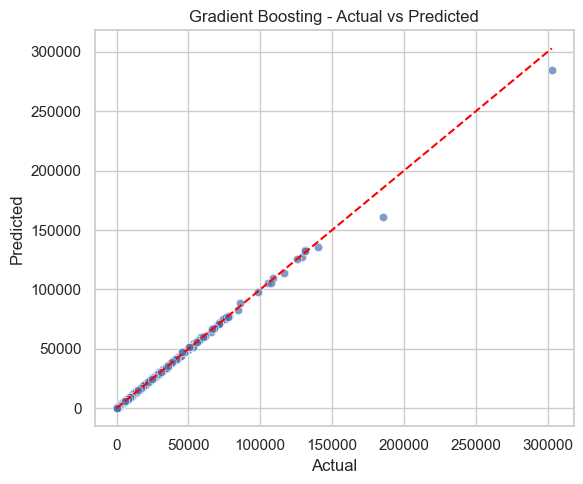

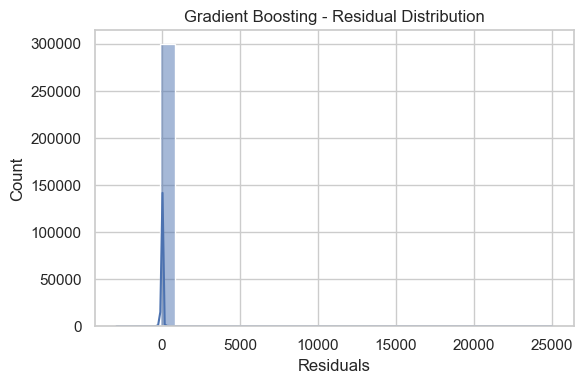

In [62]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42)
gb_pipeline = run_model("Gradient Boosting", gb_model, X_train_df, X_test_df, y_train, y_test)



🚀 Running Model: Hist Gradient Boosting

📊 Evaluation Metrics for Hist Gradient Boosting:

MAE         : 48.4796
MSE         : 752408.5481
RMSE        : 867.4149
R2 Score    : 0.7747



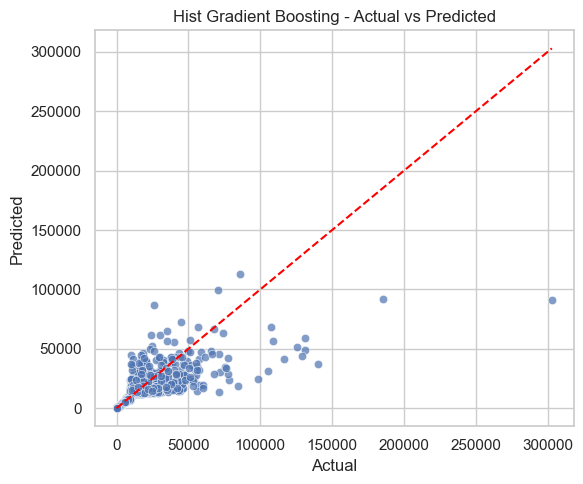

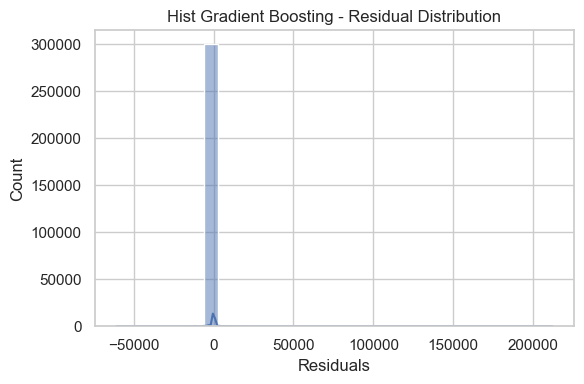

In [63]:
from sklearn.ensemble import HistGradientBoostingRegressor

hg_model = HistGradientBoostingRegressor(random_state=42)
hg_pipeline = run_model("Hist Gradient Boosting", hg_model, X_train_df, X_test_df, y_train, y_test)


In [64]:
from sklearn.ensemble import StackingRegressor

sg_model = StackingRegressor(random_state=42, estimators=5)
sg_pipeline = run_modekl("Stacking Regressor", sg_model, X_train_df, X_test_df, y_train, y_test)

TypeError: __init__() got an unexpected keyword argument 'random_state'

#### Visualization of Results

In [ ]:
# Create a summary DataFrame
results_df = pd.DataFrame(model_results).sort_values(by='RMSE')

print("\n📌 Summary of Model Performance:\n")
display(results_df.set_index("Model"))

# Plot Comparison
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE', 'R2 Score']),
            x='value', y='Model', hue='variable')
plt.title("Model Comparison Metrics")
plt.xlabel("Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


In [ ]:
# Save results to CSV
results_df.to_csv("model_comparison_results.csv", index=False)


#### Stacking Ensemble

In [ ]:
estimators = [
    ('ridge', Ridge()),
    ('rf', RandomForestRegressor(n_estimators=200, random_state=42)),
    ('hgb', HistGradientBoostingRegressor(random_state=42))
]

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=GradientBoostingRegressor(n_estimators=200, random_state=42)
)

stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)

stack_results = {
    "RMSE": mean_squared_error(y_test, y_pred_stack, squared=False),
    "MAE": mean_absolute_error(y_test, y_pred_stack),
    "R2": r2_score(y_test, y_pred_stack)
}

print("Stacking Model Performance:", stack_results)


In [ ]:
import warnings, os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path
warnings.filterwarnings("ignore") # keep notebook tidy

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["figure.dpi"] = 120

DATA_PATH = "./world_trade_synth_fast.csv" # <-- adjust if needed
OUTDIR = Path("./nb_artifacts")
OUTDIR.mkdir(parents=True, exist_ok=True)

## Combined Model ready jupyter notebook

Cell 1: Setup & Imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

# Storage for results
model_results = []
model_predictions = {}


Cell 2: Evaluation & Visualization Functions

In [ ]:
def evaluate_model(model_name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        "Model": model_name,
        "MAE": mae,
        "MSE": mse,
        "RMSE": rmse,
        "R2 Score": r2
    }

def run_model(model_name, model, X_train, X_test, y_train, y_test):
    print(f"\n{'='*30}")
    print(f"🚀 Running Model: {model_name}")
    print(f"{'='*30}\n")

    # Fit & predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Store evaluation
    results = evaluate_model(model_name, y_test, y_pred)
    model_results.append(results)
    model_predictions[model_name] = y_pred

    # Print metrics
    for k, v in results.items():
        if k != 'Model':
            print(f"{k:<10}: {v:.4f}")

    # Actual vs Predicted
    plt.figure(figsize=(6, 5))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.7)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"{model_name} - Actual vs Predicted")
    plt.tight_layout()
    plt.show()

    # Residuals
    residuals = y_test - y_pred
    plt.figure(figsize=(6, 4))
    sns.histplot(residuals, bins=30, kde=True)
    plt.title(f"{model_name} - Residual Distribution")
    plt.xlabel("Residuals")
    plt.tight_layout()
    plt.show()


Cell 3: Load Data & Preprocessing (X_train, y_train, etc.)

(Paste your existing preprocessing logic here, with MinMaxScaler and OneHotEncoder setup)
This should produce:
X_train_df, X_test_df, y_train, y_test

Cell 4: Define All Models

In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
    HistGradientBoostingRegressor, BaggingRegressor, StackingRegressor, VotingRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Base Models
base_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "SVR": make_pipeline(StandardScaler(), SVR()),
    "KNN Regressor": make_pipeline(StandardScaler(), KNeighborsRegressor()),
    "MLP Regressor": make_pipeline(StandardScaler(), MLPRegressor(random_state=42, max_iter=500))
}

# Ensemble Models
bagging_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=42)
voting_model = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42, verbosity=0)),
    ('lgbm', LGBMRegressor(random_state=42, verbose=-1)),
])
stacking_model = StackingRegressor(
    estimators=[
        ('ridge', Ridge()),
        ('rf', RandomForestRegressor(random_state=42)),
        ('xgb', XGBRegressor(random_state=42, verbosity=0))
    ],
    final_estimator=GradientBoostingRegressor(random_state=42)
)

ensemble_models = {
    "Bagging": bagging_model,
    "Voting": voting_model,
    "Stacking": stacking_model
}

# Final model list
all_models = {**base_models, **ensemble_models}


from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import (
    RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor,
    HistGradientBoostingRegressor, BaggingRegressor, StackingRegressor, VotingRegressor
)
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Base Models
base_models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "ElasticNet": ElasticNet(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Extra Trees": ExtraTreesRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42, verbose=-1),
    "CatBoost": CatBoostRegressor(verbose=0, random_state=42),
    "SVR": make_pipeline(StandardScaler(), SVR()),
    "KNN Regressor": make_pipeline(StandardScaler(), KNeighborsRegressor()),
    "MLP Regressor": make_pipeline(StandardScaler(), MLPRegressor(random_state=42, max_iter=500))
}

# Ensemble Models
bagging_model = BaggingRegressor(base_estimator=DecisionTreeRegressor(), random_state=42)
voting_model = VotingRegressor(estimators=[
    ('rf', RandomForestRegressor(random_state=42)),
    ('xgb', XGBRegressor(random_state=42, verbosity=0)),
    ('lgbm', LGBMRegressor(random_state=42, verbose=-1)),
])
stacking_model = StackingRegressor(
    estimators=[
        ('ridge', Ridge()),
        ('rf', RandomForestRegressor(random_state=42)),
        ('xgb', XGBRegressor(random_state=42, verbosity=0))
    ],
    final_estimator=GradientBoostingRegressor(random_state=42)
)

ensemble_models = {
    "Bagging": bagging_model,
    "Voting": voting_model,
    "Stacking": stacking_model
}

# Final model list
all_models = {**base_models, **ensemble_models}


Cell 5+: Run Each Model

In [ ]:
for name, model in all_models.items():
    run_model(name, model, X_train_df, X_test_df, y_train, y_test)


OR

run_model("Random Forest", all_models["Random Forest"], X_train_df, X_test_df, y_train, y_test)


In [ ]:
results_df = pd.DataFrame(model_results).sort_values(by='RMSE')

print("\n📌 Final Model Comparison:")
display(results_df.set_index("Model"))

# Plot metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE', 'R2 Score']),
            x='value', y='Model', hue='variable')
plt.title("Model Comparison Metrics")
plt.xlabel("Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


Cell 6: Compare All Results

results_df = pd.DataFrame(model_results).sort_values(by='RMSE')

print("\n📌 Final Model Comparison:")
display(results_df.set_index("Model"))

# Plot metrics
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df.melt(id_vars='Model', value_vars=['MAE', 'RMSE', 'R2 Score']),
            x='value', y='Model', hue='variable')
plt.title("Model Comparison Metrics")
plt.xlabel("Score")
plt.ylabel("Model")
plt.tight_layout()
plt.show()


SAve results

In [ ]:
results_df.to_csv("model_comparison_results.csv", index=False)
